In [1]:
import torch
import torchvision

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

data_transform = transforms.ToTensor()
train_data = MNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = MNIST(root='./data', train=False,
                                  download=True, transform=data_transform)
print('Train data, number of images: ', len(train_data))
print('Test data, numtorchvision.datasets.FashionMNISTber of images: ', len(test_data))

Train data, number of images:  60000
Test data, numtorchvision.datasets.FashionMNISTber of images:  10000


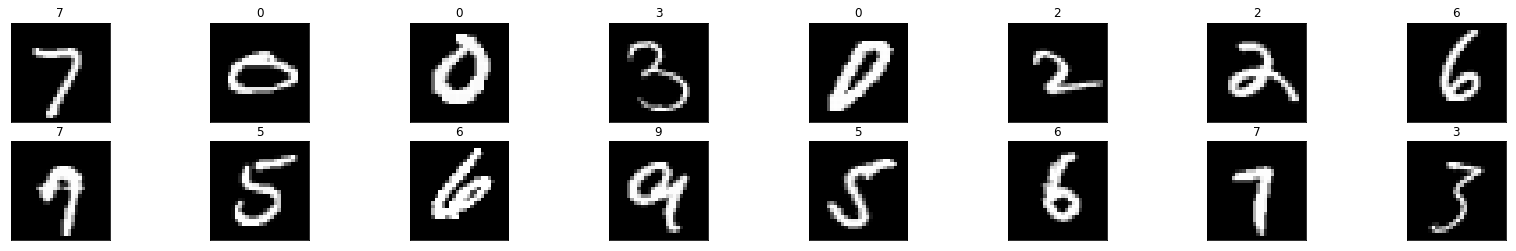

In [2]:
batch_size = 16
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size = batch_size,shuffle=True)

classes =['0','1','2','3','4','5','6','7','8','9']

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(28, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [3]:
import torch.nn as nn
import torch.nn.functional as F
core_size = 3
p=0.4
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 gray,10 deepth,core_size
        # input size = (1*28*28)
        self.conv1 = nn.Conv2d(1,10,core_size)
        #size = (10*26*26)
        self.pool = nn.MaxPool2d(2,2)
        # size =  10*13*13
        self.conv2 = nn.Conv2d(10,20,core_size)
        # size =  20*11*11
        # after pool size =  20*5*5
        self.fc1 = nn.Linear(20*5*5,100)
        self.fc1_drop = nn.Dropout(p=p)
        self.out = nn.Linear(100,10)
        
    # define the feedforward behavior
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.out(x)
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)

Net (
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear (500 -> 100)
  (fc1_drop): Dropout (p = 0.4)
  (out): Linear (100 -> 10)
)


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(),lr = 0.001,momentum=0.9)

In [5]:
from torch.autograd import Variable

def train(n_epochs):
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # wrap them in a torch Variable
            inputs, labels = Variable(inputs), Variable(labels)        

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            running_loss += loss.data[0]
            if batch_i % 1000 == 999:    # print every 1000 mini-batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [6]:
# define the number of epochs to train for
n_epochs = 5 # start small to see if your model works, initially

# call train
train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.5169855401515961
Epoch: 1, Batch: 2000, Avg. Loss: 0.4941652193292975
Epoch: 1, Batch: 3000, Avg. Loss: 0.3443797050341964
Epoch: 2, Batch: 1000, Avg. Loss: 0.24720131688704713
Epoch: 2, Batch: 2000, Avg. Loss: 0.21661910496046766
Epoch: 2, Batch: 3000, Avg. Loss: 0.18730598537158222
Epoch: 3, Batch: 1000, Avg. Loss: 0.15680811562226155
Epoch: 3, Batch: 2000, Avg. Loss: 0.16085775446286424
Epoch: 3, Batch: 3000, Avg. Loss: 0.13771982360375115
Epoch: 4, Batch: 1000, Avg. Loss: 0.1270391019823146
Epoch: 4, Batch: 2000, Avg. Loss: 0.12446171787852654
Epoch: 4, Batch: 3000, Avg. Loss: 0.11772122978675179
Epoch: 5, Batch: 1000, Avg. Loss: 0.10325256000779336
Epoch: 5, Batch: 2000, Avg. Loss: 0.10139964807790239
Epoch: 5, Batch: 3000, Avg. Loss: 0.09845059596118517
Finished Training


In [7]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # wrap them in a torch Variable
    # volatile means we do not have to track how the inputs change
    inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i]
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.057502

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 97% (986/1010)
Test Accuracy of     4: 98% (966/982)
Test Accuracy of     5: 98% (876/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 98% (1010/1028)
Test Accuracy of     8: 97% (946/974)
Test Accuracy of     9: 96% (974/1009)

Test Accuracy (Overall): 98% (9805/10000)


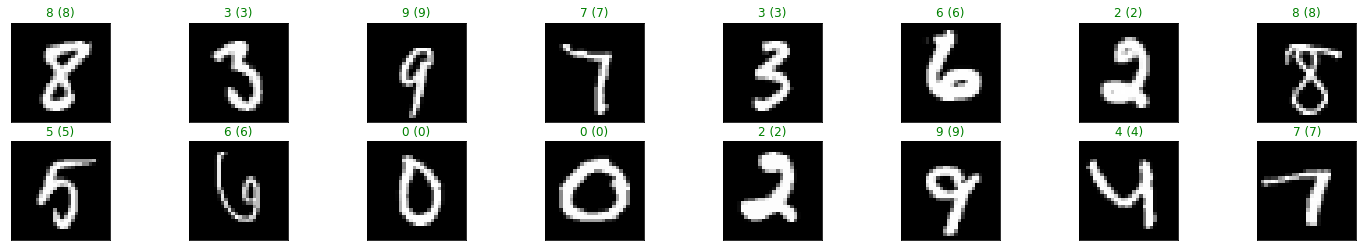

In [9]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(Variable(images, volatile=True)).data.max(1)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# Save Model

In [11]:
model_dir = './saved_models/'
model_name = 'model_1.pt'
torch.save(net.state_dict(), model_dir+model_name)

# Load Model

In [12]:
net = Net()
net.load_state_dict(torch.load('saved_models/model_1.pt'))
print(net)

Net (
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear (500 -> 100)
  (fc1_drop): Dropout (p = 0.4)
  (out): Linear (100 -> 10)
)


First convolutional layer


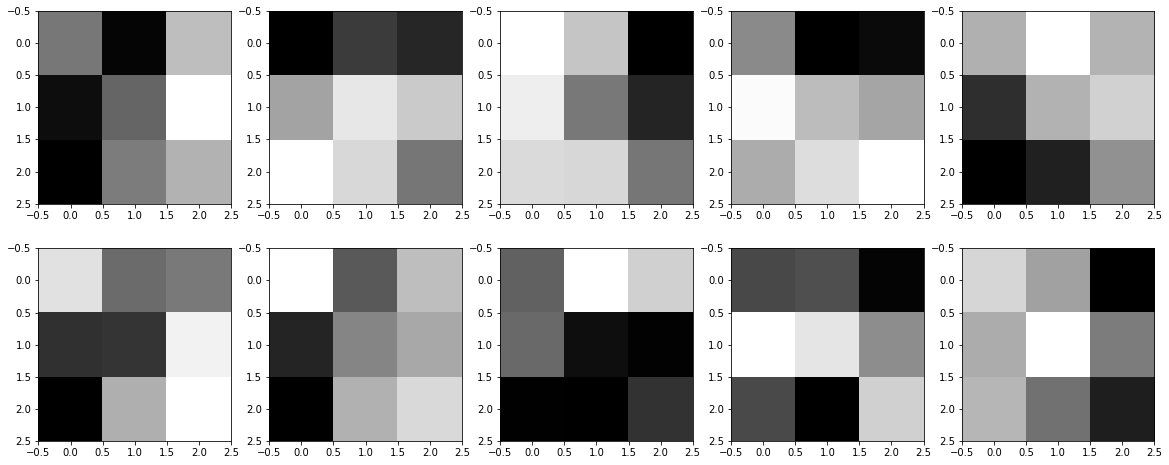

In [16]:
# Get the weights in the first conv layer
weights = net.conv2.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()

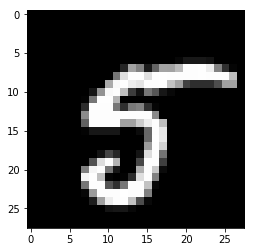

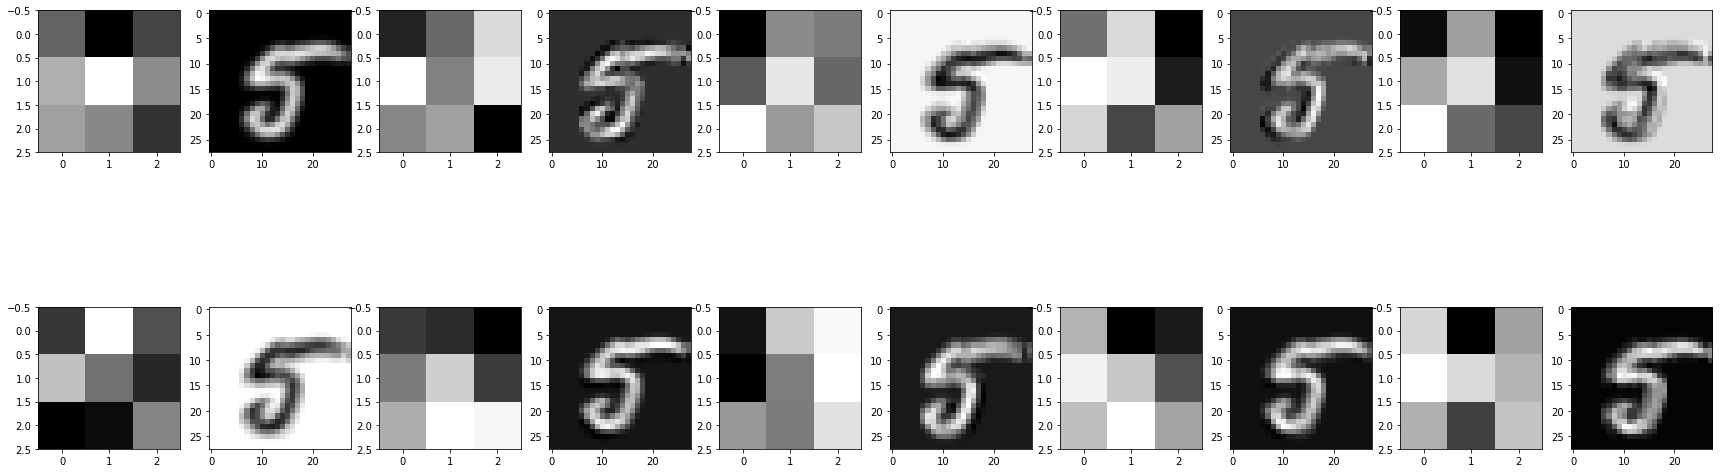

In [17]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 3
img = np.squeeze(images[idx])

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

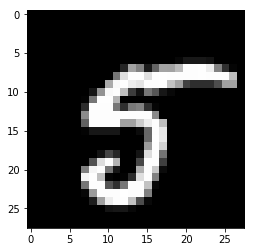

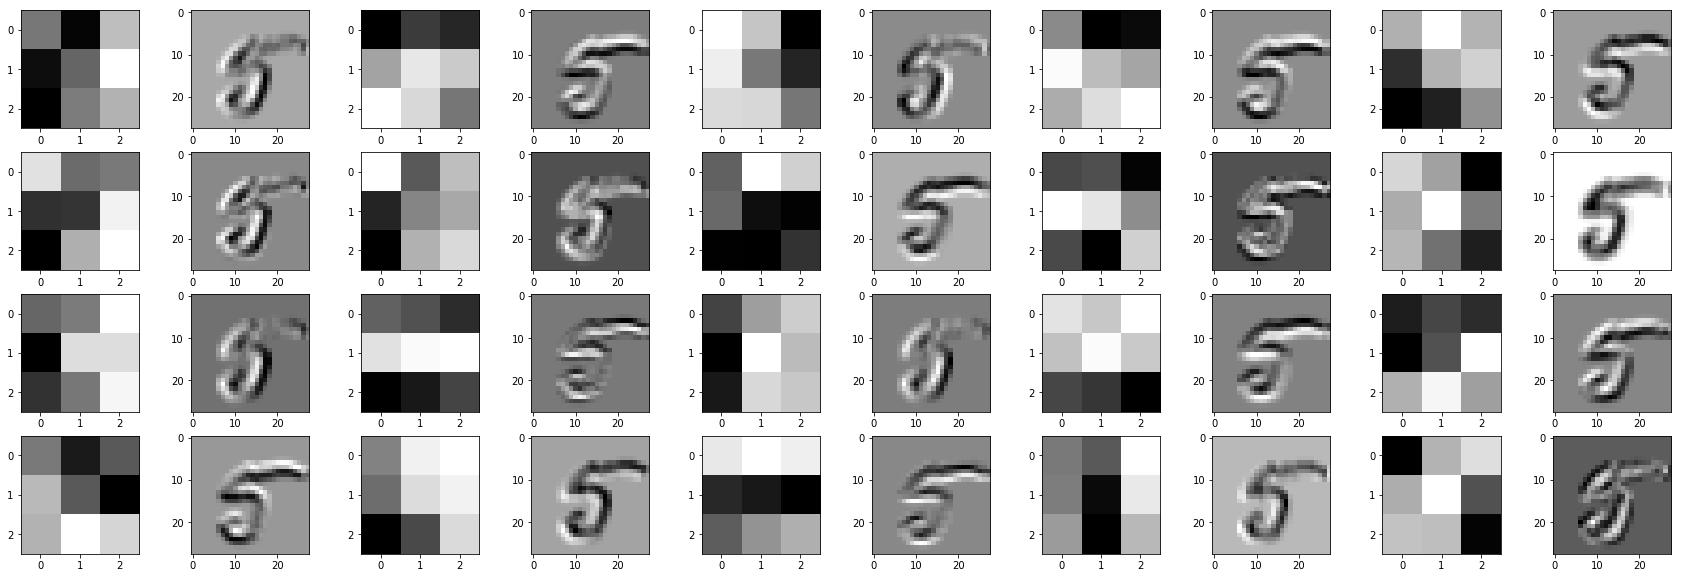

In [18]:
# Same process but for the second conv layer (20, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = net.conv2.weight.data
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2*2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()